In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from tqdm.notebook import tqdm, trange
from random import randint
import multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool

In [2]:
df = pd.read_csv('fake_post_data.csv')

In [3]:
df.head()

,Unnamed: 0,101,102,103,104,105,106,107,108,109,...,121,122,123,124,125,126,127,128,129,130
0,0,3,5,1,3,4,1,5,4,2,...,3,4,5,2,1,2,5,4,5,4
1,1,2,5,4,5,2,3,3,1,2,...,1,2,3,4,3,1,3,2,5,5
2,2,1,5,5,1,2,3,3,3,4,...,5,5,3,4,4,2,2,5,1,3
3,3,5,2,2,4,5,5,5,4,5,...,5,2,4,3,3,3,3,5,5,4
4,4,2,3,2,5,4,4,5,4,5,...,5,5,4,3,3,1,5,5,1,2


In [4]:
df.columns

Index(['Unnamed: 0', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '110', '111', '112', '113', '114', '115', '116', '117', '118',
       '119', '120', '121', '122', '123', '124', '125', '126', '127', '128',
       '129', '130'],
      dtype='object')

In [5]:
class oneHotStudent():
    '''
    Turn each student into a one-hot vector encoding of their FCI answers, creating a format to run
    through thought2vec.
    
    The class is called on each row of FCI test data, incidating if the pre or posttest is used.
    '''
    def __init__(self, df_student, pre):
        self.student = df_student.reset_index()
        self.pre = pre
        self.df_onehot = self.oneHotQ(self.student,self.pre)
        
    @staticmethod
    def oneHotQ(student,pre=True):
        '''
        Turn each student's answers to the FCI into a 30 x 150 matrix of one-hot encoded answers to each
        FCI question. Answering 'A' to the first question gives a vector [1,0,0,...,0]; answering 'B' to 
        that same question gives [0,1,0,0,...,0]; answering E to the last question gives [0,0,0,...,1].

        This preprocesses each student's answer into a form to run through Thought2vec
        '''
        if pre == True:
            col_list = ['001', '002', '003', '004', '005', '006', '007', '008',
           '009', '010', '011', '012', '013', '014', '015', '016', '017', '018',
           '019', '020', '021', '022', '023', '024', '025', '026', '027', '028',
           '029', '030']
        else:
            col_list = ['101', '102', '103', '104', '105', '106', '107', '108',
           '109', '110', '111', '112', '113', '114', '115', '116', '117', '118',
           '119', '120', '121', '122', '123', '124', '125', '126', '127', '128',
           '129', '130']
        
        zero_matrix = np.zeros((30,150))
        df_onehot = pd.DataFrame(zero_matrix, columns=range(1,151))

        for row in range(0,student.shape[0]):
            for i, col in enumerate(col_list):
                #zeros = [0]*150
                val = int(student.iloc[row,i+2])
                #zeros[val-1+i*5] = 1
                #df_onehot.loc[row*30+i] = zeros
                df_onehot.iloc[row*30+i, val-1+i*5] = 1

        return df_onehot
    
    
    def trainTargetDF(self):
        '''
        Arrange each question to become the training vector and other vectors to become target vectors. When
        selecting a question after question 1 as trainging question, the other vectors will create a cylce.
        For example, if question 28 is chosen, then the order of target question vectors will become 
        29, 30, 1, 2, 3, ..., 26, 27.
        Question should be an integer between 1 and 30, inclusive.
        '''
        for question in range(1, 31):
            df_train = self.df_onehot.loc[question - 1]
            df_target = pd.concat([self.df_onehot.loc[question:30], self.df_onehot.loc[:question-2]])
            for i in range(0,29):
                yield np.array(df_train).astype(np.float64), np.array(df_target).astype(np.float64)[i]

### Making thought2vec Class

Code below comes from [here](https://github.com/cbellei/word2veclite/blob/master/word2veclite/word2veclite.py)

Changed to fit needs of test answer vectors

In [6]:
def initialize(V, N):
    """
    Initialize the weights of the neural network.
    :param V: size of the vocabulary
    :param N: size of the hidden layer
    :return: weights W1, W2
    """
    np.random.seed(100)
    W1 = np.random.rand(V, N)
    W2 = np.random.rand(N, V)

    return W1, W2




def softmax(x):
    """Calculate softmax based probability for given input vector
    # Arguments
        x: numpy array/list
    # Returns
        softmax of input array
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [7]:
class Thought2Vec:
    """
    Python implementation of Word2Vec.
    # Arguments
        method : `str`
            choose method for word2vec (options: 'cbow', 'skipgram')
            [default: 'cbow']
        window_size: `integer`
            size of window [default: 1]
        n_hidden: `integer`
            size of hidden layer [default: 2]
        n_epochs: `integer`
            number of epochs [default: 1]
        learning_rate: `float` [default: 0.1]
        corpus: `str`
            corpus text
    """
    def __init__(self, method='cbow', window_size=1, n_hidden=2, n_epochs=1, 
                 corpus=pd.DataFrame(), learning_rate=0.1, early_stop = 1):
        self.window = window_size
        self.N = n_hidden
        self.n_epochs = n_epochs
        self.corpus = corpus
        self.eta = learning_rate
        self.early_stop = early_stop
        if method == 'cbow':
            self.method = self.cbow
        elif method == 'skipgram':
            self.method = self.skipgram
        else:
            raise ValueError("Method not recognized. Aborting.")
    
    def onehotvecs(self, df):
        r = df.shape[0]
        stu_dict = {}
        for i in range(r):
            stu = oneHotStudent(df[i:i+1],pre=0)
            stu_dict[i] = stu.df_onehot
        return stu_dict
    
    def cbow(self, context, label, W1, W2, loss):
        """
        Implementation of Continuous-Bag-of-Words Word2Vec model
        :param context: all the context words (these represent the inputs)
        :param label: the center word (this represents the label)
        :param W1: weights from the input to the hidden layer
        :param W2: weights from the hidden to the output layer
        :param loss: float that represents the current value of the loss function
        :return: updated weights and loss
        """
        # context is 'x' from tokenizer, it is a c x V matrix
        # label is 'y' from tokenizer, it is a 1 x V matrix
        
        label = pd.DataFrame(label).T
        x = np.matrix(np.mean(context, axis=0))
        
        # x is a 1 x V matrix
        # W1 is a VxN matrix
        # h is a N x 1 matrix
        h = np.matmul(W1.T, x.T)
        
        # u is a V x 1 matrix
        u = np.matmul(W2.T, h)
        
        # W2 is an N x V matrix
        # y_pred is a V x 1 matrix
        y_pred = softmax(u)
        # e is a V x 1 matrix
        e = -label.T + y_pred
        e = e.to_numpy()
        # h is N x 1 and e is V x 1 so dW2 is N x V
        dW2 = np.outer(h, e)
        # x.T is a V x 1 matrix, W2e is a Nx1 so dW1 this is V x N
        dW1 = np.outer(x.T, np.matmul(W2, e))

        new_W1 = W1 - self.eta * dW1
        new_W2 = W2 - self.eta * dW2

        # label is a 1xV matrix so label.T is a Vx1 matrix
        label = label.to_numpy()
        loss += -float(np.sum([label.T == 1])) + np.log(np.sum(np.exp(u)))

        return new_W1, new_W2, loss

    def skipgram(self, context, x, W1, W2, loss):
        """
        Implementation of Skip-Gram Word2Vec model
        :param context: all the context words (these represent the labels)
        :param x: the center word (this represents the input)
        :param W1: weights from the input to the hidden layer
        :param W2: weights from the hidden to the output layer
        :param loss: float that represents the current value of the loss function
        :return: updated weights and loss
        """
        # context is "x" from tokenizer, it is a c x V matrix
        # "x" is "y" from tokenizer, it is a 1 x V matrix
        # W1 has dimension V x N (N= number of features, V = vocab size)
        # x has dimension V x 1
        h = np.matmul(W1.T, x.T)
        # h has dimension N x 1
        # W2 has dimension N x V
        # u has dimension V x 1
        u = np.dot(W2.T, h)
        # y_pred has dimension V x 1
        y_pred = softmax(u)

        # context is a c by V matrix
        # e is a V x c matrix
        e = np.outer(y_pred,np.array([1]*context.shape[0]))-context.T

        # np.sum(e, axis=1) is a V x 1 vectors
        # h is an N x 1 Vector
        # dW2 is a N x V matrix
        dW2 = np.outer(h, np.sum(e, axis=1))
        # x is a V x 1 matrix
        # np.dot(W2, np.sum(e,axis=1)) is a product (N x V) (Vx 1) is Nx1
        # dW1 is an V x N matrix
        dW1 = np.outer(x.T, np.dot(W2, np.sum(e, axis=1)))

        new_W1 = W1 - self.eta * dW1
        new_W2 = W2 - self.eta * dW2

        loss += - np.sum([[label.T == 1] for label in context]) + len(context) * np.log(np.sum(np.exp(u)))

        return new_W1, new_W2, loss
    
    def trainTargetDF(self, df):
        '''
        Arrange each question to become the training vector and other vectors to become target vectors. When
        selecting a question after question 1 as trainging question, the other vectors will create a cylce.
        For example, if question 28 is chosen, then the order of target question vectors will become 
        29, 30, 1, 2, 3, ..., 26, 27.
        Question should be an integer between 1 and 30, inclusive.
        '''
        for question in range(1, 31):
            df_train = df.loc[question - 1]
            df_target = pd.concat([df.loc[question:30], df.loc[:question-2]])
            yield np.array(df_train).astype(np.float64), np.array(df_target).astype(np.float64)
            

    def predict(self, x, W1, W2):
        """Predict output from input data and weights
        :param x: input data
        :param W1: weights from input to hidden layer
        :param W2: weights from hidden layer to output layer
        :return: output of neural network
        """
        h = np.mean([np.matmul(W1.T, xx) for xx in x], axis=0)
        u = np.dot(W2.T, h)
        return softmax(u)

    def run(self):
        """
        Main method of the Word2Vec class.
        :return: the final values of the weights W1, W2 and a history of the value of the loss function vs. epoch
        """
        if len(self.corpus) == 0:
            raise ValueError('You need to specify a corpus of text.')

            
        print("Creating one-hot student answer vectors")
        cores=mp.cpu_count()
        stu_dict = {}
        df_split = np.array_split(self.corpus, cores, axis=0)

        # create the multiprocessing pool
        pool = Pool(cores)

        # process the DataFrame by mapping function to each df across the pool
        df_out = np.vstack(pool.map(self.onehotvecs, df_split))

        # close down the pool and join
        pool.close()
        pool.join()
        pool.clear()

        print("Creating student answer dictionary")
        row_count = 0
        for i in range(0,cores):
            for j in range(0,len(df_out[i][0])):
                stu_dict[row_count] = df_out[i][0][j]
                row_count += 1
                
        # initialize weight matrices
        print("Initializing weights")
        V = stu_dict[0].shape[1]
        W1, W2 = initialize(V, self.N)

        loss_vs_epoch = []
        loss_low = np.inf
        
        print("Begining training")
        for e in trange((self.n_epochs), desc='Epochs'):
            loss = 0.0
            rand_student_order = np.random.choice(self.corpus.shape[0], 
                                                  self.corpus.shape[0], 
                                                  replace=False)
            # shuffle data without replacement
            for i in tqdm(rand_student_order, desc='Students', leave=False):
                for center, context in self.trainTargetDF(stu_dict[i]):
                    W1, W2, loss = self.method(context, center, W1, W2, loss)
            loss_vs_epoch.append(loss)
            
            if loss < loss_low:
                loss_low = loss
                W1_best, W2_best = W1, W2
                
            # Early stopping and returning best result
            if loss > loss_vs_epoch[max(0,e-self.early_stop)]:
                print("Training complete. Loss now increasing.")
                return W1_best, W2_best, loss_vs_epoch

        print("Training complete.")
        return W1, W2, loss_vs_epoch

In [8]:
corpus2 = df[:10]

skip = Thought2Vec(method="skipgram", corpus=corpus2,
                window_size=1, n_hidden=10,
                n_epochs=300, learning_rate=int(1e-9),
                early_stop = 5)
W1, W2, loss_vs_epoch = skip.run()

Creating one-hot student answer vectors
Creating student answer dictionary
Initializing weights
Begining training


Training complete. Loss now increasing.


In [9]:
W1[0]

array([0.54340494, 0.27836939, 0.42451759, 0.84477613, 0.00471886,
       0.12156912, 0.67074908, 0.82585276, 0.13670659, 0.57509333])

In [10]:
W1[1]

array([0.89132195, 0.20920212, 0.18532822, 0.10837689, 0.21969749,
       0.97862378, 0.81168315, 0.17194101, 0.81622475, 0.27407375])

In [11]:
W1[40]

array([0.0606697 , 0.94983694, 0.60865905, 0.67200268, 0.46277352,
       0.7042731 , 0.18106714, 0.64758218, 0.56810873, 0.95413831])

In [12]:
W1.T[0]

array([0.54340494, 0.89132195, 0.43170418, 0.59884338, 0.74247969,
       0.97500649, 0.37625245, 0.27676506, 0.50869889, 0.54040458,
       0.77828922, 0.02317814, 0.5003559 , 0.09043279, 0.11004833,
       0.18967353, 0.20820724, 0.11353758, 0.7070435 , 0.07957344,
       0.41709074, 0.95237685, 0.26336578, 0.21134789, 0.16926891,
       0.60511204, 0.19083605, 0.96582582, 0.99219069, 0.01782318,
       0.00993369, 0.04910597, 0.06043793, 0.46737799, 0.45955367,
       0.63508815, 0.13844892, 0.89767831, 0.93925558, 0.1068655 ,
       0.0606697 , 0.79669024, 0.88538733, 0.57612541, 0.38100727,
       0.06776774, 0.15671587, 0.21128188, 0.89066405, 0.75715828,
       0.55252942, 0.51558849, 0.31763167, 0.09813216, 0.24910739,
       0.3137655 , 0.64280185, 0.00887518, 0.30838671, 0.82964966,
       0.40984647, 0.5666854 , 0.76914268, 0.24170214, 0.87712078,
       0.85847487, 0.50070912, 0.35141828, 0.28971077, 0.86146826,
       0.08862541, 0.73041149, 0.1222318 , 0.76605648, 0.78098

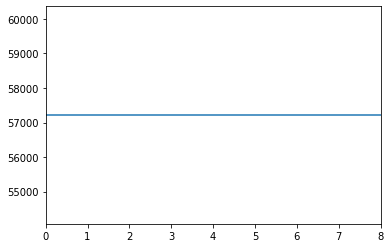

In [13]:
pd.Series(loss_vs_epoch).plot()
plt.show()
plt.close()

In [15]:
stu = oneHotStudent(df[99:100],pre=0)

skip.predict(x=np.array(stu.df_onehot),W1=W1,W2=W2)

array([0.00498862, 0.00488382, 0.00565415, 0.00800499, 0.00646294,
       0.00927354, 0.00750326, 0.00620201, 0.00907189, 0.00855699,
       0.00462898, 0.00936995, 0.0024096 , 0.00750244, 0.00834871,
       0.00586076, 0.00477783, 0.00281181, 0.00387459, 0.00421799,
       0.00908292, 0.00920619, 0.00776089, 0.00503585, 0.00589929,
       0.01062665, 0.01219578, 0.00579122, 0.00327313, 0.0054185 ,
       0.00433758, 0.00789209, 0.00402686, 0.0114383 , 0.0040603 ,
       0.00656993, 0.00807061, 0.01051047, 0.00965735, 0.00395803,
       0.00435907, 0.00735962, 0.0083507 , 0.00634567, 0.00784537,
       0.0080965 , 0.00649344, 0.00999989, 0.01304533, 0.0058003 ,
       0.00200591, 0.00282126, 0.00762565, 0.01102362, 0.00607343,
       0.00406533, 0.00181725, 0.00441743, 0.0150581 , 0.00533923,
       0.00553207, 0.00640324, 0.00572706, 0.00914885, 0.00581202,
       0.00467611, 0.02375668, 0.00526758, 0.00337688, 0.00597388,
       0.00631785, 0.00412096, 0.00477528, 0.00858505, 0.00532

In [16]:
skip.predict(x=np.array(stu.df_onehot),W1=W1,W2=W2).max(), skip.predict(x=np.array(stu.df_onehot),W1=W1,W2=W2).min()

(0.023756683676711056, 0.0018172543434670225)

In [17]:
corpus2 = df[:10]

cbow = Thought2Vec(method="cbow", corpus=corpus2,
                window_size=1, n_hidden=10,
                n_epochs=300, learning_rate=int(1e-9))
W1_c, W2_c, loss_vs_epoch_c = cbow.run()

Creating one-hot student answer vectors
Creating student answer dictionary
Initializing weights
Begining training


Training complete. Loss now increasing.


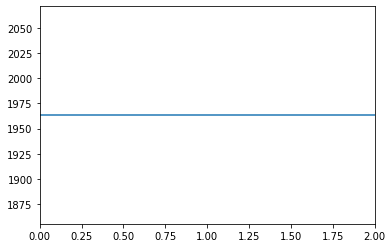

In [18]:
pd.Series(loss_vs_epoch_c).plot()
plt.show()
plt.close()

In [19]:
def visualize_weights(matrix, contrast = None, ret = False, title = None):
    if title is None:
        title = 'Weight Matrix Visualization'
        
    if contrast is not None:
        matrix -= np.mean(matrix)
        matrix = matrix / (contrast * (1 + np.abs(matrix / contrast)))

    max_size = np.max(np.abs(matrix))

    num_dims = matrix.shape[1]
    fig, ax = plt.subplots()
    fig.set_size_inches(h = 8, w = 16)
    fig.suptitle(title, fontsize = 24)
    fig.subplots_adjust(top = 0.93, bottom = 0.1)

    plot = ax.pcolormesh(matrix, cmap='PiYG', vmin=-max_size, vmax=max_size, snap=True)

    ax.set_xlabel('Dimension', fontsize = 20)
    ax.set_xticks(np.arange(0, num_dims + 1, 1))
    ax.set_xticks(np.arange(0.5, num_dims, 1), minor = True)
    ax.set_xticklabels([])
    ax.set_xticklabels(np.arange(1, 1 + num_dims), minor = True)

    ax.set_ylabel('Question', fontsize = 20)
    ax.set_yticks(np.linspace(0, 150, 31))
    ax.set_yticklabels([])
    ax.set_yticks(np.linspace(3, 147, 30), minor = True)
    ax.set_yticklabels(np.arange(1, 31), minor = True)

    ax.tick_params(axis = 'y', which = 'minor', length = 0, labelsize = 12)
    ax.tick_params(axis = 'x', which='minor', length=0, labelsize=12)

    ax.grid(axis='y', which='major', color='black',linewidth=0.5, linestyle='dashed')
    ax.grid(axis='x', which='major', color='black',linewidth=1)

    cbar = fig.colorbar(plot, ax = ax, pad = 0.01, extend = 'neither')
    cbar.ax.tick_params(labelsize=14)

    fig.canvas.set_window_title(title)

    if ret:
        return fig
        
    plt.show()

def visualize_weights_expanded(matrix, contrast=None, Q=30, title = None):
    if title is None:
        title = 'Weight Matrix Visualization'
    if contrast is not None:
        matrix -= np.mean(matrix)
        matrix = matrix / (contrast * (1 + np.abs(matrix / contrast)))

    max_size = np.max(np.abs(matrix))

    num_responses, num_dims = matrix.shape
    num_subcolumns = num_responses // Q
    expanded_matrix = (np.eye(num_subcolumns)[:, :, None] * matrix.reshape(Q, num_subcolumns, 1, num_dims)).transpose(0, 1, 3, 2).reshape(num_responses, num_subcolumns * num_dims)

    fig, ax = plt.subplots()
    fig.set_size_inches(h = 8, w = 16)
    fig.suptitle(title, fontsize=24)
    fig.subplots_adjust(top=0.93, bottom=0.1)

    plot = ax.pcolormesh(expanded_matrix, cmap='PiYG', vmin = -max_size, vmax = max_size, snap = True)

    ax.set_ylabel('Question', fontsize=20)

    ax.set_yticks(np.linspace(0, 150, 31))
    ax.set_yticklabels(np.arange(1, 31), verticalalignment = 'bottom')

    #ax.set_yticks(np.linspace(0, 180, 181), minor = True)
    #ax.set_yticklabels([], minor=True)

    ax.set_xlabel('Dimension', fontsize=20)

    ax.set_xticks(np.arange(0, num_subcolumns * num_dims + 1, num_subcolumns))
    ax.set_xticklabels(np.arange(1, 1 + num_dims), horizontalalignment = 'left')

    ax.set_xticks(np.arange(num_subcolumns * num_dims + 1), minor=True)
    ax.set_xticklabels([], minor=True)

    ax.tick_params(axis='y', which='major', length=3, labelsize=12)
    ax.tick_params(axis='x', which='major', length=6, labelsize=12)

    ax.grid(axis='y', which='major', color='black', linewidth=0.5, linestyle = 'dashed')
    ax.grid(axis='x', which='major', color = 'black', linewidth = 1)
    ax.grid(axis='x', which='minor', color='gray', linewidth=0.5, linestyle = 'dotted')

    cbar = fig.colorbar(plot, ax=ax, pad=0.01, extend='neither')
    cbar.ax.tick_params(labelsize=14)

    fig.canvas.set_window_title(title)
    plt.show()


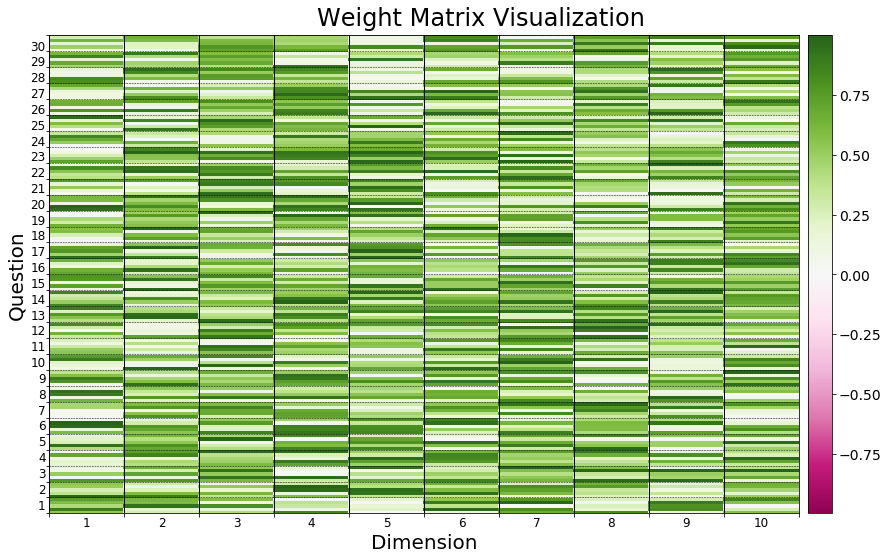

In [20]:
visualize_weights(W1)

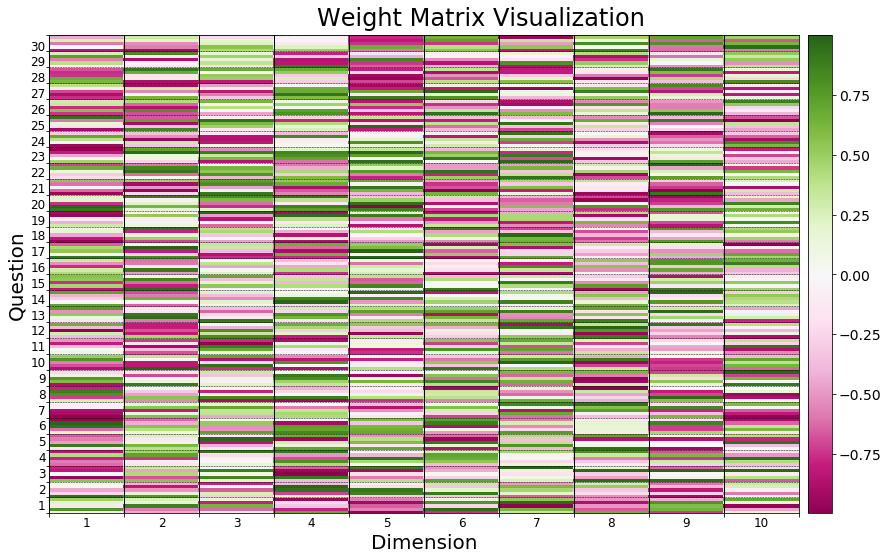

In [21]:
visualize_weights(W1*2 - 1)

In [22]:
W1_c[0]

array([0.54340494, 0.27836939, 0.42451759, 0.84477613, 0.00471886,
       0.12156912, 0.67074908, 0.82585276, 0.13670659, 0.57509333])

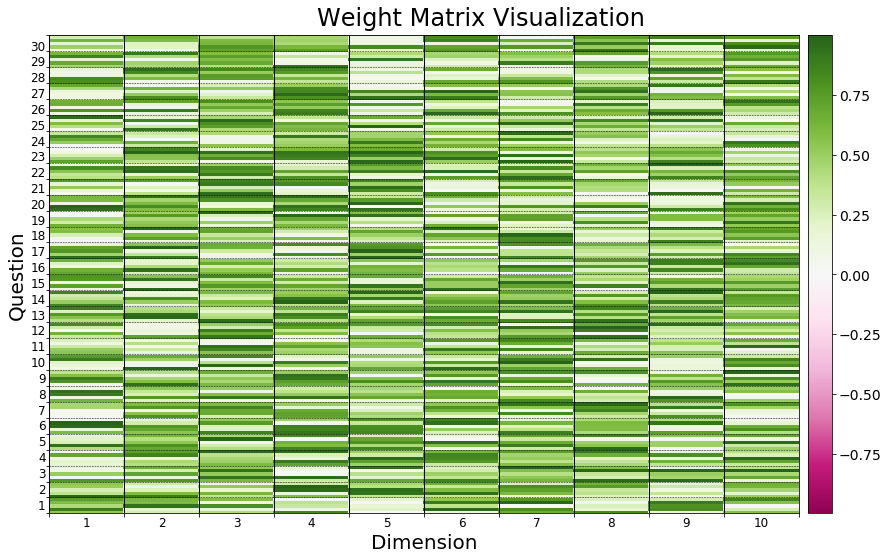

In [23]:
visualize_weights(W1_c)

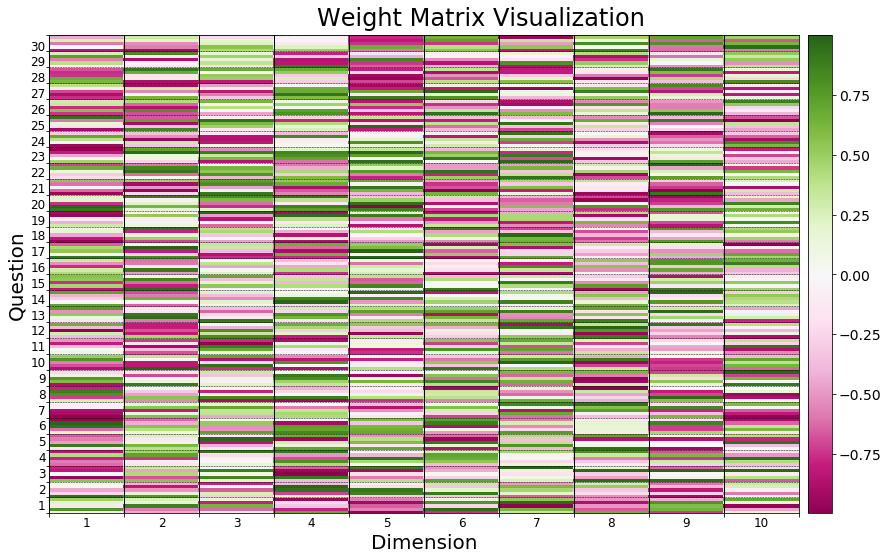

In [24]:
visualize_weights(W1_c*2-1)

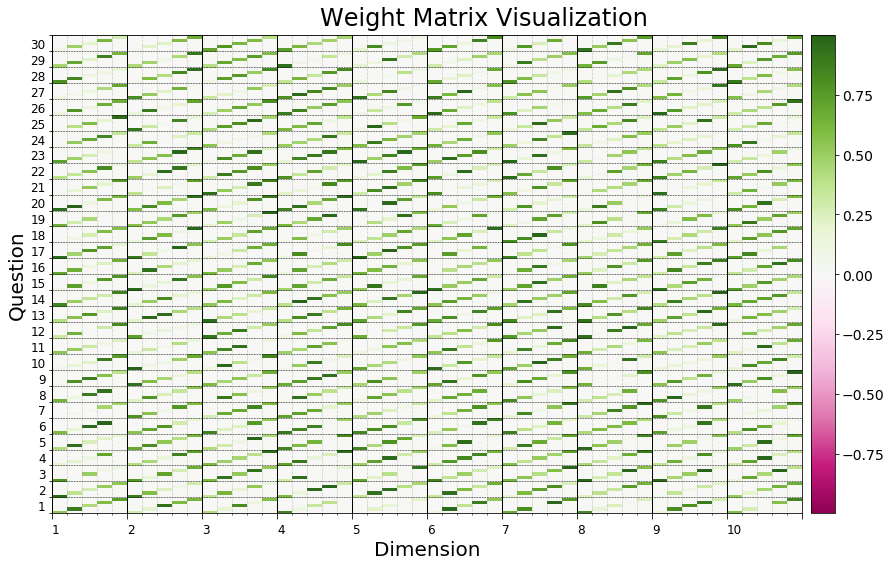

In [25]:
visualize_weights_expanded(W1_c)

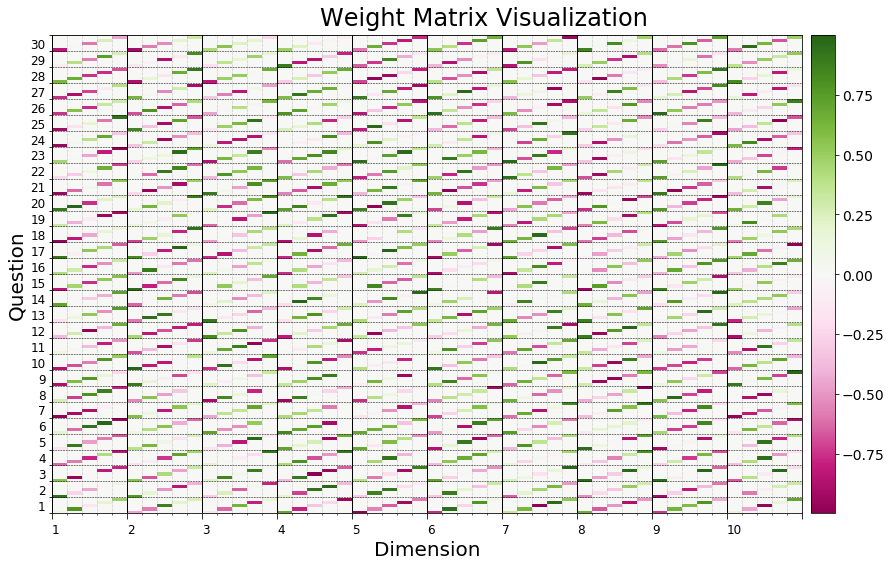

In [26]:
visualize_weights_expanded(W1_c*2-1)